# Zadanie 6

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]

Polecane źródła - teoria + intuicja:
- https://distill.pub/2019/paths-perspective-on-value-learning/
- https://www.youtube.com/watch?v=0iqz4tcKN58&ab_channel=SteveBrunton

In [7]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt

In [8]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((observation_space, action_space))

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        return self.q_table[state, action]

    def update(self, state: np.ndarray, action: np.ndarray, reward: float, new_state: np.ndarray) -> None:
        """Update Q-value of given state and action."""
        max_future_q = np.max(self.q_table[new_state])
        current_q = self(state, action)

        self.q_table[state, action] = current_q + self.learning_rate * (reward + self.gamma * max_future_q - current_q)
    
    def make_action(self, state: np.ndarray) -> np.ndarray:
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_space)
        else:
            action = self.get_best_action(state)
        
        return action

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        q_values = self.q_table[state]
        return np.argmax(q_values)

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        return f"Observation space: {self.observation_space}, action space: {self.action_space}, learning rate: {self.learning_rate}, gamma: {self.gamma}, epsilon: {self.epsilon}"

    def __str__(self):
        return self.__repr__()

# Eksperymenty

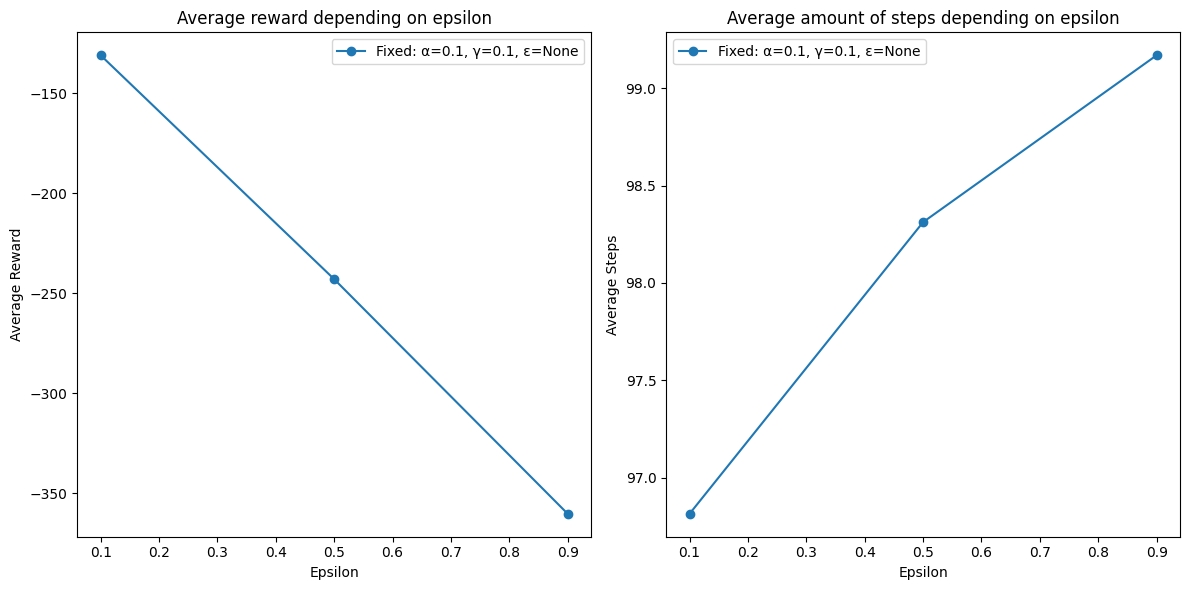

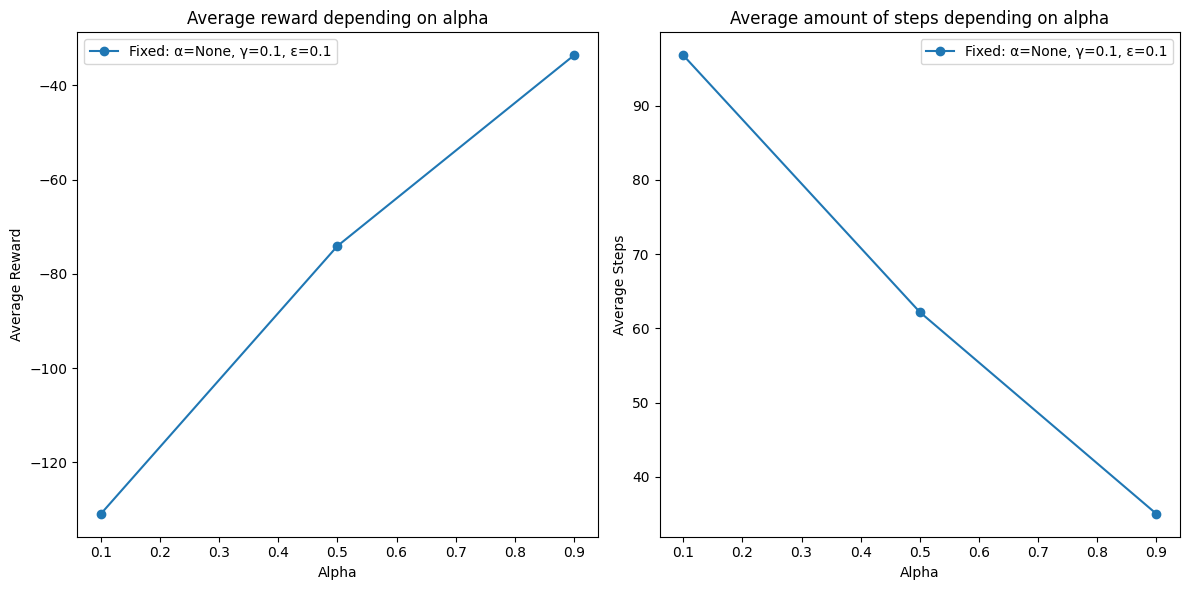

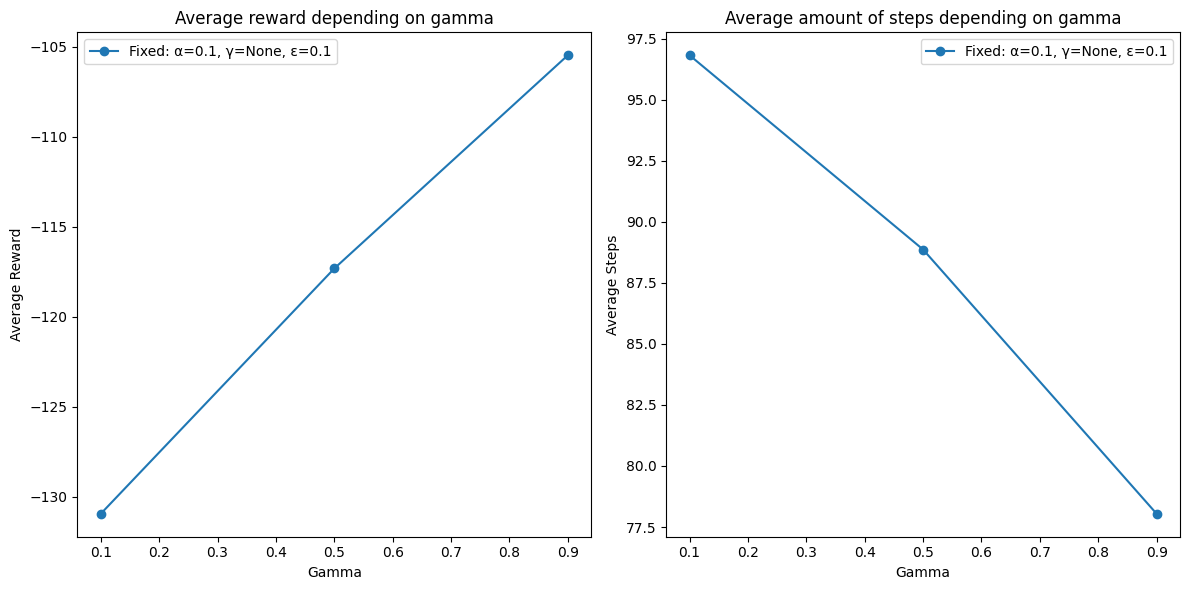

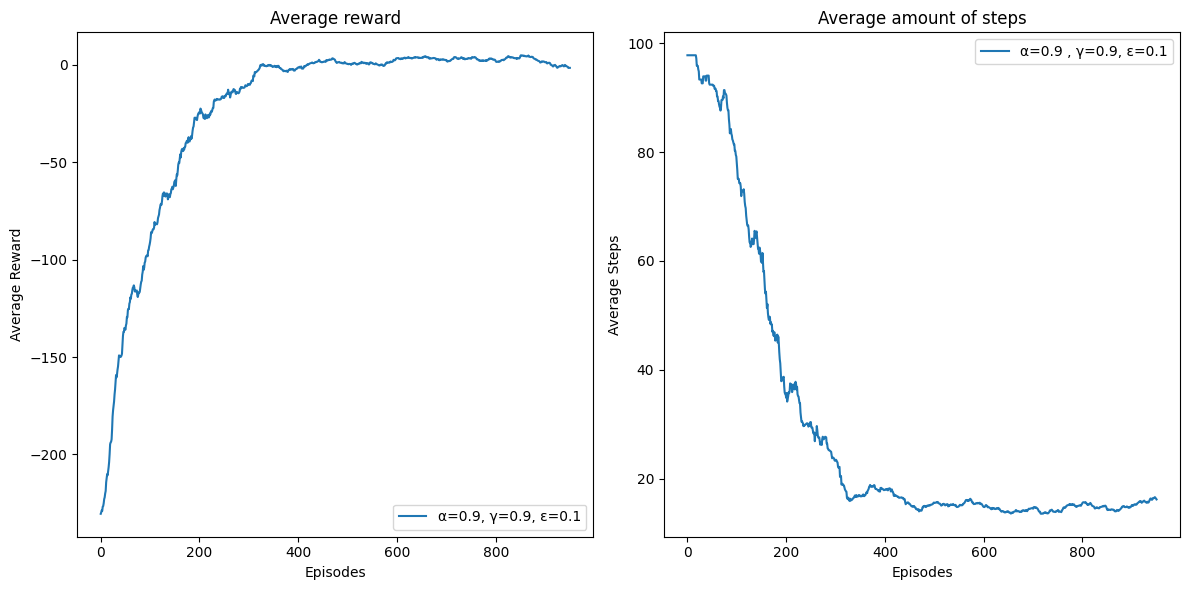

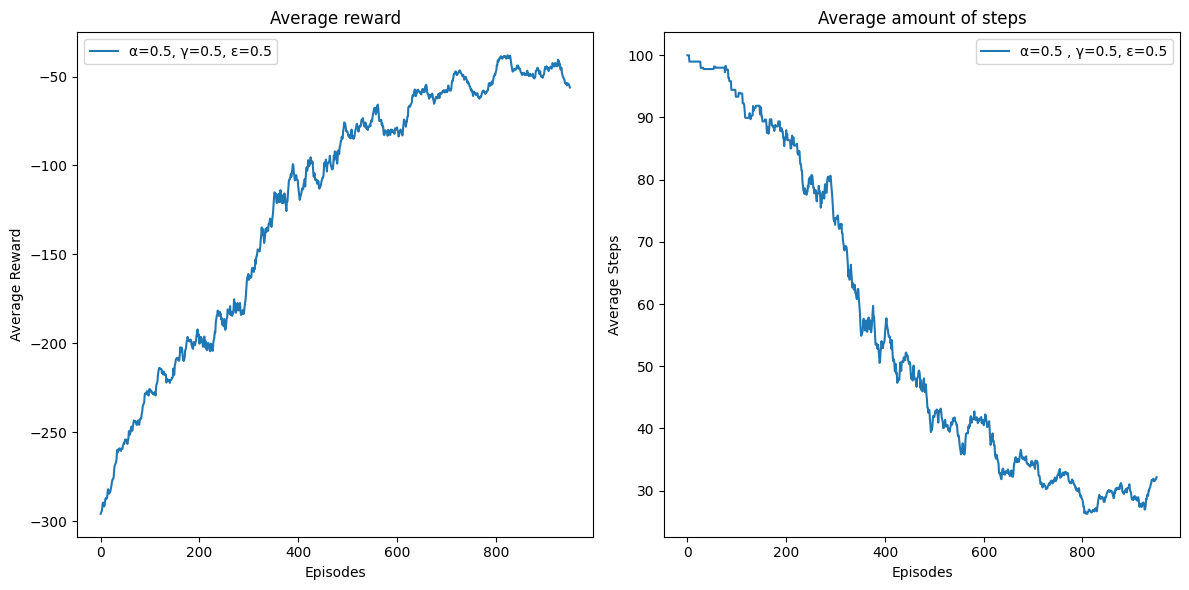

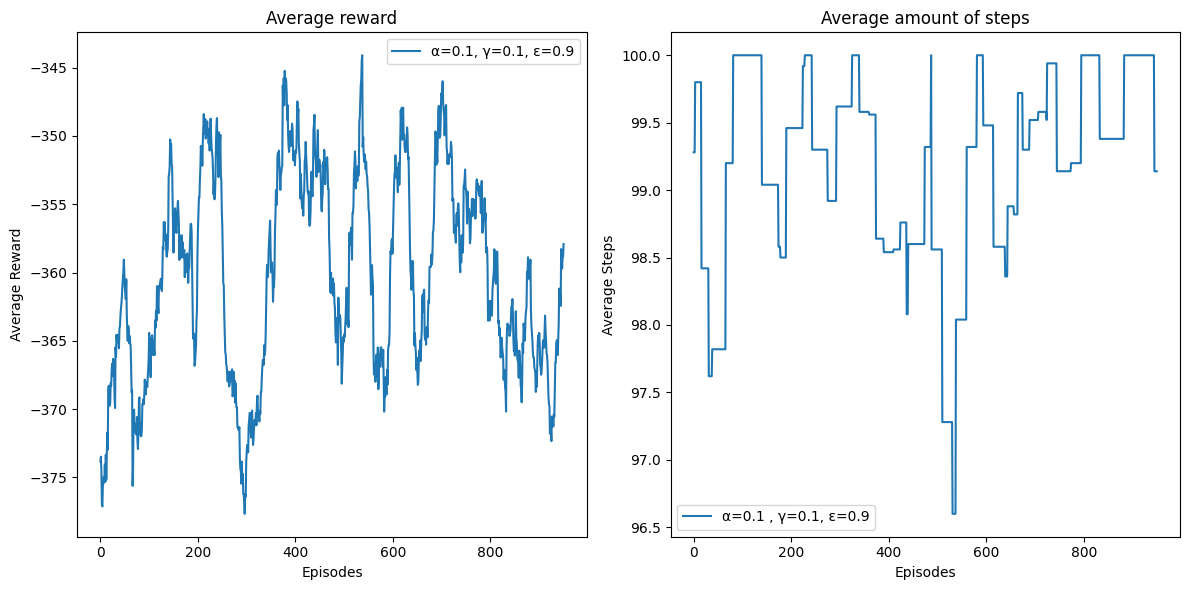

In [9]:
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

EPISODES = 1000
MAX_STEPS = 100
results = {}
mean_results = {}
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
epsilons = [0.1, 0.5, 0.9]

env = gym.make('Taxi-v3')
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            solver = QLearningSolver(500, 6, learning_rate=alpha, gamma=gamma, epsilon=epsilon)
            rewards_per_episode = []
            steps_per_episode = []

            for i in range(EPISODES): 
                state, info = env.reset()
                done = False
                total_reward = 0
                steps = 0

                while not done and steps < MAX_STEPS:
                    action = solver.make_action(state)
                    next_state, reward, done, truncated, info = env.step(action)
                    solver.update(state, action, reward, next_state)
                    state = next_state

                    total_reward += reward
                    steps += 1

                rewards_per_episode.append(total_reward)
                steps_per_episode.append(steps)

            mean_results[(alpha, gamma, epsilon)] = {
                "avg_reward": np.mean(rewards_per_episode),
                "avg_steps": np.mean(steps_per_episode),
            }
            results[(alpha, gamma, epsilon)] = {
                "rewards": rewards_per_episode,
                "steps": steps_per_episode,
            }
env.close()

for param_name, param_values, fixed_alpha, fixed_gamma, fixed_epsilon in [
    ("epsilon", epsilons, 0.1, 0.1, None),
    ("alpha", alphas, None, 0.1, 0.1),
    ("gamma", gammas, 0.1, None, 0.1),
]:
    avg_rewards = []
    avg_steps = []
    
    for param in param_values:
        alpha = fixed_alpha if fixed_alpha is not None else param
        gamma = fixed_gamma if fixed_gamma is not None else param
        epsilon = fixed_epsilon if fixed_epsilon is not None else param

        result = mean_results[(alpha, gamma, epsilon)]
        avg_rewards.append(result["avg_reward"])
        avg_steps.append(result["avg_steps"])
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(param_values, avg_rewards, marker='o', label=f"Fixed: α={fixed_alpha}, γ={fixed_gamma}, ε={fixed_epsilon}")
    plt.xlabel(param_name.capitalize())
    plt.ylabel("Average Reward")
    plt.title(f"Average reward depending on {param_name}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(param_values, avg_steps, marker='o', label=f"Fixed: α={fixed_alpha}, γ={fixed_gamma}, ε={fixed_epsilon}")
    plt.xlabel(param_name.capitalize())
    plt.ylabel("Average Steps")
    plt.title(f"Average amount of steps depending on {param_name}")
    plt.legend()


    plt.tight_layout()
    plt.show()

best = [0.9, 0.9, 0.1]
mid = [0.5, 0.5, 0.5]
worst = [0.1, 0.1, 0.9]
for param_values in [best, mid, worst]:
    alpha = param_values[0]
    gamma = param_values[1]
    epsilon = param_values[2]

    data = results[(alpha, gamma, epsilon)]
    avg_rewards = moving_average(data["rewards"])
    avg_steps = moving_average(data["steps"])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(avg_rewards, label=f"α={alpha}, γ={gamma}, ε={epsilon}")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title(f"Average reward")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(avg_steps, label=f"α={alpha} , γ={gamma}, ε={epsilon}")
    plt.xlabel("Episodes")
    plt.ylabel("Average Steps")
    plt.title(f"Average amount of steps")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Wnioski

1. Dla problemu Taxi najlepszy jest wysoki learning rate, w tym wypadku 0.9. Mimo tego, że dla innych zadań do tej pory zbyt wysoki learning rate powodował gorsze wyniki, w przypadku tego zadania jest na odwrót. Według mnie wynika to z tego, że Taxi jest prostym problemem, a plansza pozostaje zawsze taka sama, nie jest losowa. Alpha też najbardziej wpływa na wyniki, różnica między średnią liczbą kroków między 0.1 a 0.9 learning rate wynosi około 60.
2. Gamma podobnie jak alpha powinna być jak największa, chociaż mniej wpływa na wyniki, tutaj różnica w średniej liczbie kroków to około 20.
3. Epsilon powinien być mniejszy. Najlepszy byłby wysoki epsilon na początku działania kodu, który jest co raz mniejszy w trakcie działania, aby początkowo promować eksplorację. Jeśli epsilon jest wysoki przez cały czas działania programu, to kod mimo uczenia się nie może wykorzystać tej wiedzy, większość jego ruchów będzie losowych.